# Simple classification example

In this example, we consider the dataset introduced by Agrawal et al.  The dataset has 25,000 samples. We compare Random Forest classifier from Scikit-learn and Adaptive Random Forest classifier from River.   

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import accuracy_score
from river.ensemble import AdaptiveRandomForestClassifier


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 


In [3]:
# Dataset from https://github.com/AlexImb/automl-streams/blob/master/demos/_datasets/agrawal_gen.csv
csv_file = "./datasets/agrawal_gen_abrupt.csv"

df = pd.read_csv(csv_file,
                    names=["salary", "commission", "age", "education level", "make of car", "zipcode", "house value", "years house owned", "loan", "y"])
df.head()

,salary,commission,age,education level,make of car,zipcode,house value,years house owned,loan,y
0,68757.426754,58022.846494,21.0,4.0,5.0,7.0,221792.307247,10.0,27402.870141,0
1,126298.059683,0.000000,60.0,0.0,19.0,5.0,248027.000114,6.0,197321.294347,0
2,20642.840226,65253.012270,30.0,2.0,5.0,2.0,591488.097260,17.0,36810.494158,0
3,74382.160911,67141.427442,60.0,4.0,2.0,8.0,123653.321624,4.0,354680.807306,0
4,44492.145159,83925.141993,33.0,0.0,2.0,7.0,204227.660125,11.0,360978.690701,0


In [4]:
df.describe()

,salary,commission,age,education level,make of car,zipcode,house value,years house owned,loan,y
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,2.500000e+04,25000.000000,25000.000000,25000.000000
mean,84972.795032,20264.628004,49.734840,1.980320,9.528520,3.988480,5.031361e+05,15.546240,252406.744346,0.402520
std,37597.219134,27474.706289,17.559453,1.412888,5.764321,2.600611,3.075721e+05,8.606724,144648.181065,0.490415
min,20008.016424,0.000000,20.000000,0.000000,0.000000,0.000000,5.020484e+04,1.000000,31.627375,0.000000
25%,52305.865382,0.000000,35.000000,1.000000,4.000000,2.000000,2.559315e+05,8.000000,127555.674975,0.000000
50%,84918.344035,0.000000,49.000000,2.000000,10.000000,4.000000,4.567160e+05,16.000000,252597.079320,0.000000
75%,117495.813013,41081.562259,65.000000,3.000000,14.000000,6.000000,7.095024e+05,23.000000,378789.775283,1.000000
max,149992.810065,84995.082709,80.000000,4.000000,19.000000,8.000000,1.349538e+06,30.000000,499904.721197,1.000000


In [5]:
csv_file = "./datasets/agrawal_gen_abrupt.csv"

df = pd.read_csv(csv_file,
                    names=["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "y"])

df_test = df[22000:25000]
df = df[0:22000]

df.head()


,x0,x1,x2,x3,x4,x5,x6,x7,x8,y
0,68757.426754,58022.846494,21.0,4.0,5.0,7.0,221792.307247,10.0,27402.870141,0
1,126298.059683,0.000000,60.0,0.0,19.0,5.0,248027.000114,6.0,197321.294347,0
2,20642.840226,65253.012270,30.0,2.0,5.0,2.0,591488.097260,17.0,36810.494158,0
3,74382.160911,67141.427442,60.0,4.0,2.0,8.0,123653.321624,4.0,354680.807306,0
4,44492.145159,83925.141993,33.0,0.0,2.0,7.0,204227.660125,11.0,360978.690701,0


In [6]:
df.shape

(25000, 10)

## Data exploration

In [7]:
print(len(df.y))
df['y'].value_counts()

25000


0    14937
1    10063
Name: y, dtype: int64

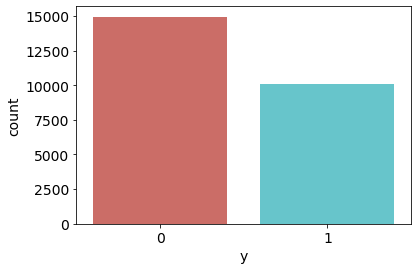

In [8]:
plt.rc("font", size=14)
sns.countplot(x='y',data=df, palette='hls')
plt.show()


In [9]:
df['y'].values.shape

(25000,)

In [10]:
scaler = StandardScaler()
X = df.copy()
X.drop("y", axis=1, inplace=True)
X[X.columns] = scaler.fit_transform(X)
X

,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,-0.431300,1.374318,-1.636464,1.429498,-0.785628,1.158028,-0.914743,-0.644421,-1.555556
1,1.099179,-0.737589,0.584606,-1.401639,1.643154,0.388963,-0.829445,-1.109183,-0.380831
2,-1.711064,1.637480,-1.123909,0.013929,-0.785628,-0.764636,0.287262,0.168913,-1.490517
3,-0.281692,1.706214,0.584606,1.429498,-1.306081,1.542561,-1.233826,-1.341564,0.707068
4,-1.076714,2.317105,-0.953058,-1.401639,-1.306081,1.158028,-0.971851,-0.528230,0.750608
...,...,...,...,...,...,...,...,...,...
24995,0.423851,-0.737589,0.242903,-0.693855,0.428763,-1.533701,2.318492,-1.225373,-1.398224
24996,-1.639362,0.573827,-0.668305,-0.693855,-1.306081,-1.533701,1.816275,0.866056,-0.776598
24997,0.571919,-0.737589,-1.123909,-0.693855,-1.132597,-1.149168,1.672108,1.330819,1.664225
24998,0.703634,-0.737589,0.584606,0.013929,0.775732,1.542561,-1.424730,-0.179658,-1.073691


In [11]:
# Cleaning and preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

X = df.copy()
y = X['y'].values
X.drop("y", axis=1, inplace=True)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = y.reshape(len(y),1)
print(X.shape, y.shape)

(25000, 9) (25000, 1)


##  Batch learning

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0, shuffle=False)

In [13]:
X_test

,x0,x1,x2,x3,x4,x5,x6,x7,x8
10000,0.931844,-0.737589,-1.180860,-1.401639,-0.785628,-1.149168,1.879816,0.285104,-1.550785
10001,0.211363,-0.737589,0.185953,0.013929,-1.479566,-0.764636,1.241538,1.214628,0.006559
10002,-1.307102,2.134948,0.641557,1.429498,-1.132597,0.773495,-0.991348,-1.109183,-0.042870
10003,1.106829,-0.737589,0.299854,1.429498,-0.438659,-0.764636,1.717052,1.214628,-1.405999
10004,1.252911,-0.737589,0.413755,0.013929,-1.653050,-1.533701,1.820741,-0.063468,0.030406
...,...,...,...,...,...,...,...,...,...
24995,0.423851,-0.737589,0.242903,-0.693855,0.428763,-1.533701,2.318492,-1.225373,-1.398224
24996,-1.639362,0.573827,-0.668305,-0.693855,-1.306081,-1.533701,1.816275,0.866056,-0.776598
24997,0.571919,-0.737589,-1.123909,-0.693855,-1.132597,-1.149168,1.672108,1.330819,1.664225
24998,0.703634,-0.737589,0.584606,0.013929,0.775732,1.542561,-1.424730,-0.179658,-1.073691


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0, shuffle=False)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
X_test = X_test.iloc[0:6000]
y_test = y_test[0:6000]
print(X_train.shape, X_test.shape)

/var/folders/qm/6sftmgzj257f31tbfcdmd4g40000gn/T/ipykernel_86969/2349217925.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


(10000, 9) (6000, 9)


In [15]:
# Predict the test set
from river import metrics
from river import stream
metric = metrics.Accuracy() # Use accuracy as the metric
i = 0   
t = [] 
m = []  

for xi, yi in stream.iter_array(X_test.to_numpy(), y_test, feature_names=["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]):
    xi = np.fromiter(xi.values(), dtype=float)
    y_pred= rfc.predict(xi.reshape(1,-1))  
    metric = metric.update(yi[0], y_pred[0]) 
    t.append(i)
    m.append(metric.get()*100)
    i = i+1

[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[1]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[1]
[1]

/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando


[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]


/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/seshu/opt/anaconda3/envs/sail3.8/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Rando

In [16]:
from river.linear_model import LogisticRegression
X = 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.36, random_state=0, shuffle=False)
X_train = X_train.to_numpy()
metric_rfc = metrics.Accuracy() 
model_rfc = AdaptiveRandomForestClassifier()
i = 0 
t_inc = [] 
m_inc = [] 
y_pr_inc = []

for xi, yi in stream.iter_array(X_train, y_train, feature_names=["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]):
    y_pred_inc= model_rfc.predict_one(xi)  
    y_pr_inc.append(y_pred_inc)
    yi = yi[0]    
    model_rfc.learn_one(xi,yi) 
    metric_rfc = metric_rfc.update(yi, y_pred_inc) 
    t_inc.append(i)
    m_inc.append(metric_rfc.get()*100)
    i = i+1

In [ ]:
# from river.linear_model import LogisticRegression
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.36, random_state=0, shuffle=False)
# X_train = X_train.to_numpy()
# metric_rfc = metrics.Accuracy() 
# model_rfc = AdaptiveRandomForestClassifier()
# i = 0 
# t_inc = [] 
# m_inc = [] 
# y_pr_inc = []

# for xi, yi in stream.iter_array(X_train, y_train, feature_names=["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]):
#     y_pred_inc= model_rfc.predict_one(xi)  
#     y_pr_inc.append(y_pred_inc)
#     yi = yi[0]    
#     model_rfc.learn_one(xi,yi) 
#     metric_rfc = metric_rfc.update(yi, y_pred_inc) 
#     t_inc.append(i)
#     m_inc.append(metric_rfc.get()*100)
#     i = i+1

In [19]:
from jupyterplot import ProgressPlot
import numpy as np

pp = ProgressPlot(line_names=["batch RFC", "incremental ARFC"],
                  x_lim=[0, 6000],
                  y_lim=[50,100 ])
for i in range(6000):
    pp.update([[m[i], m_inc[i+10000]]])
pp.finalize()

In [20]:
from river import drift
drift_detector = drift.ADWIN()
drifts = []
for i, val in enumerate(y_train):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.change_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)
        drift_detector.reset()   # As a best practice, we reset the detector
print(drifts)


Change detected at index 13311
[13311]
